In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Simulation parameters
dt = 0.1  # time step (ms)
T = 500   # total time (ms)
time = np.arange(0, T + dt, dt)

# Model parameters
tau_m = 10.0      # membrane time constant (ms)
E_L = -65.0       # resting potential (mV)
R_m = 10.0        # membrane resistance (MΩ)
V_th = -50.0      # threshold potential (mV)
V_reset = -65.0   # reset potential (mV)
V_peak = 0.0      # spike peak (mV)

# Generate smooth random driving current
np.random.seed()
raw_noise = np.random.randn(len(time))
I_e = gaussian_filter1d(raw_noise, sigma=150)
I_e = 1.5 + I_e * 12  # scale and shift

# Define ODE right-hand side
def dVdt(V, I):
    return (E_L - V + R_m * I) / tau_m

# Prep arrays
V_eu = np.full_like(time, E_L)
V_rk = np.full_like(time, E_L)
V_num = np.full_like(time, E_L)
V_eu_plot = np.copy(V_eu)
V_rk_plot = np.copy(V_rk)
V_num_plot = np.copy(V_num)

exp_factor = np.exp(-dt / tau_m)

# Simulation loop
for i in range(1, len(time)):
    # Euler update
    V_temp = V_eu[i-1] + dVdt(V_eu[i-1], I_e[i-1]) * dt
    if V_temp >= V_th:
        V_eu_plot[i] = V_peak
        V_eu[i] = V_reset
    else:
        V_eu_plot[i] = V_temp
        V_eu[i] = V_temp

    # RK4 update
    V0, I0 = V_rk[i-1], I_e[i-1]
    k1 = dVdt(V0, I0) * dt
    k2 = dVdt(V0 + k1/2, I0) * dt
    k3 = dVdt(V0 + k2/2, I0) * dt
    k4 = dVdt(V0 + k3, I0) * dt
    V_temp = V0 + (k1 + 2*k2 + 2*k3 + k4) / 6
    if V_temp >= V_th:
        V_rk_plot[i] = V_peak
        V_rk[i] = V_reset
    else:
        V_rk_plot[i] = V_temp
        V_rk[i] = V_temp

    # Numerical update
    V_inf = E_L + R_m * I_e[i-1]
    V_temp = V_inf + (V_num[i-1] - V_inf) * exp_factor
    if V_temp >= V_th:
        V_num_plot[i] = V_peak
        V_num[i] = V_reset
    else:
        V_num_plot[i] = V_temp
        V_num[i] = V_temp

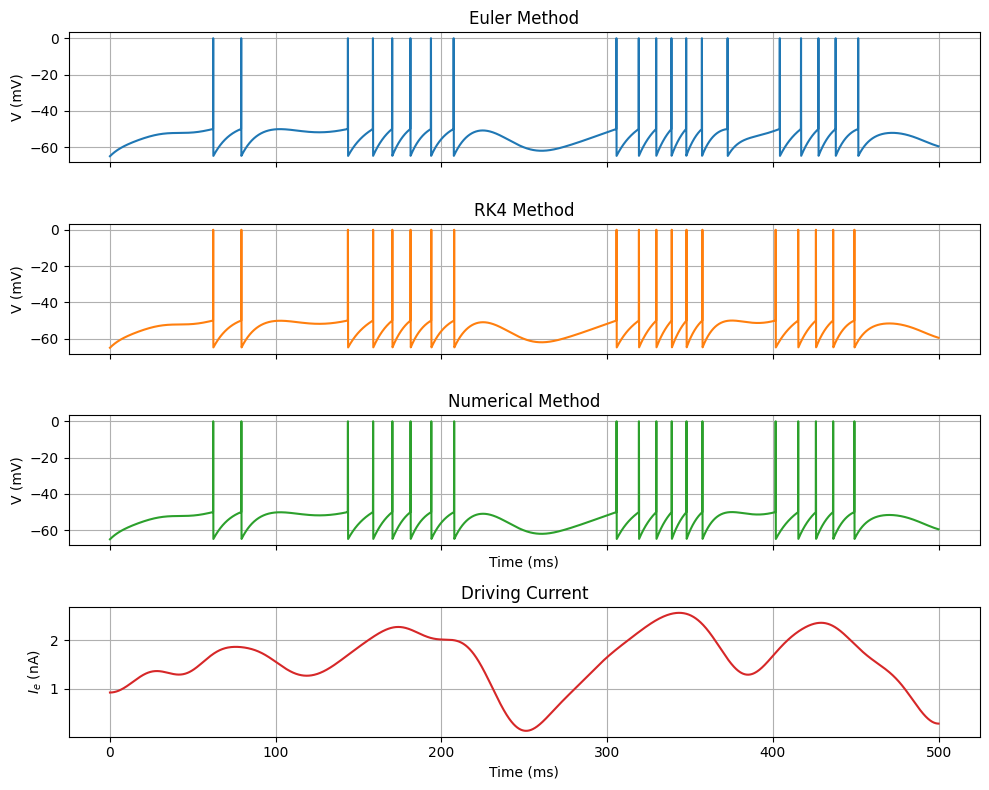

In [12]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(time, V_eu_plot, color='C0')
axes[0].set_title('Euler Method')
axes[0].set_ylabel('V (mV)')
axes[0].grid(True)

axes[1].plot(time, V_rk_plot, color='C1')
axes[1].set_title('RK4 Method')
axes[1].set_ylabel('V (mV)')
axes[1].grid(True)

axes[2].plot(time, V_num_plot, color='C2')
axes[2].set_title('Numerical Method')
axes[2].set_ylabel('V (mV)')
axes[2].set_xlabel('Time (ms)')
axes[2].grid(True)

axes[3].plot(time, I_e, color='C3')
axes[3].set_title('Driving Current')
axes[3].set_ylabel('$I_e$ (nA)')
axes[3].set_xlabel('Time (ms)')
axes[3].grid(True)

plt.tight_layout()
plt.show()
